In [17]:
"""
Deepfake Detection Training - Vision Transformer (ViT) Architecture
Dual-input model: Frequency features + MobileNet features
FIXED VERSION - All bugs corrected
"""
import numpy as np
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, 
    MultiHeadAttention, Add, GlobalAveragePooling1D,
    Reshape, concatenate, BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import Precision, Recall, AUC

In [18]:
# ============================================================
# GPU MEMORY CONFIGURATION
# ============================================================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU Memory Growth enabled for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(f"⚠ GPU Error: {e}")

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU'))} device(s)")


TensorFlow version: 2.20.0
GPU available: 0 device(s)


In [19]:
# ============================================================
# VISION TRANSFORMER COMPONENTS
# ============================================================
class PatchEmbedding(tf.keras.layers.Layer):
    """Convert image to patches and embed them"""
    def __init__(self, patch_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.projection = Dense(embed_dim)
        
    def call(self, x):
        # x shape: (batch, height, width, channels)
        batch_size = tf.shape(x)[0]
        height = tf.shape(x)[1]
        width = tf.shape(x)[2]
        channels = x.shape[3]
        
        # Calculate number of patches
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        
        # Reshape to patches
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        
        # Reshape to (batch, num_patches, patch_size*patch_size*channels)
        patch_dim = self.patch_size * self.patch_size * channels
        patches = tf.reshape(patches, [batch_size, -1, patch_dim])
        
        # Project to embedding dimension
        embedded = self.projection(patches)
        return embedded

class AddPositionEmbed(tf.keras.layers.Layer):
    """Add learnable position embeddings"""
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim = embed_dim
        self.pos_embed = self.add_weight(
            name='pos_embed',
            shape=(1, num_patches, embed_dim),
            initializer='random_normal',
            trainable=True
        )
    
    def call(self, x):
        return x + self.pos_embed

class AddClassToken(tf.keras.layers.Layer):
    """Add learnable class token"""
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.class_token = self.add_weight(
            name='class_token',
            shape=(1, 1, embed_dim),
            initializer='random_normal',
            trainable=True
        )
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        # Tile class token to batch size
        class_tokens = tf.tile(self.class_token, [batch_size, 1, 1])
        # Concatenate with patches
        return tf.concat([class_tokens, x], axis=1)

class TransformerBlock(tf.keras.layers.Layer):
    """Transformer encoder block"""
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        
        self.att = MultiHeadAttention(
            num_heads=num_heads, 
            key_dim=embed_dim // num_heads,
            dropout=dropout_rate
        )
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='gelu'),
            Dropout(dropout_rate),
            Dense(embed_dim)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)
        
    def call(self, x, training=False):
        # Multi-head attention with residual connection
        attn_output = self.att(x, x, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        # Feed-forward network with residual connection
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2


In [20]:
# ============================================================
# PATHS & FILE LISTS
# ============================================================
FAKE_FREQ_DIR = "/Applications/Tien/deepfake/Dataset/features/fake/frequency"
FAKE_MOBILE_DIR = "/Applications/Tien/deepfake/Dataset/features/fake/mobilenet"
REAL_FREQ_DIR = "/Applications/Tien/deepfake/Dataset/features/real/frequency"
REAL_MOBILE_DIR = "/Applications/Tien/deepfake/Dataset/features/real/mobilenet"

print("\n" + "="*60)
print("SCANNING DATASET")
print("="*60)

fake_files = sorted([f for f in os.listdir(FAKE_FREQ_DIR) if f.endswith('.npy')])
real_files = sorted([f for f in os.listdir(REAL_FREQ_DIR) if f.endswith('.npy')])

print(f"Found {len(fake_files)} fake samples")
print(f"Found {len(real_files)} real samples")

# Check imbalance
imbalance_ratio = max(len(fake_files), len(real_files)) / min(len(fake_files), len(real_files))
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")

# Create file lists
file_list = []
for f in fake_files:
    file_list.append((f, 1, 'fake'))
for f in real_files:
    file_list.append((f, 0, 'real'))

print(f"Total: {len(file_list)} samples")

# Split into train/val/test
train_files, test_files = train_test_split(
    file_list, test_size=0.2, random_state=42,
    stratify=[label for _, label, _ in file_list]
)
train_files, val_files = train_test_split(
    train_files, test_size=0.2, random_state=42,
    stratify=[label for _, label, _ in train_files]
)

print(f"\nTrain: {len(train_files)} samples ({len(train_files)/len(file_list)*100:.1f}%)")
print(f"Val: {len(val_files)} samples ({len(val_files)/len(file_list)*100:.1f}%)")
print(f"Test: {len(test_files)} samples ({len(test_files)/len(file_list)*100:.1f}%)")

# Data leakage check
train_set = set([(f, cls) for f, _, cls in train_files])
val_set = set([(f, cls) for f, _, cls in val_files])
test_set = set([(f, cls) for f, _, cls in test_files])

assert len(train_set & val_set) == 0, "Train/Val overlap detected!"
assert len(train_set & test_set) == 0, "Train/Test overlap detected!"
assert len(val_set & test_set) == 0, "Val/Test overlap detected!"
print("✓ No data leakage detected")


SCANNING DATASET
Found 16201 fake samples
Found 16171 real samples
Imbalance ratio: 1.00:1
Total: 32372 samples

Train: 20717 samples (64.0%)
Val: 5180 samples (16.0%)
Test: 6475 samples (20.0%)
✓ No data leakage detected


In [21]:
# ============================================================
# TF DATASET PIPELINE
# ============================================================
BATCH_SIZE = 16  # Increased from 8 to 16 for better training stability

def create_tf_dataset(file_list, batch_size=16, shuffle=True, augment=False):
    """Create optimized TensorFlow Dataset pipeline"""
    def load_data(filename, label, class_name):
        def _load_numpy(fname, lbl, cls):
            fname = fname.numpy().decode('utf-8')
            lbl = int(lbl.numpy())
            cls = cls.numpy().decode('utf-8')
            
            if cls == 'fake':
                freq_dir = FAKE_FREQ_DIR
                mobile_dir = FAKE_MOBILE_DIR
            else:
                freq_dir = REAL_FREQ_DIR
                mobile_dir = REAL_MOBILE_DIR
            
            freq = np.load(os.path.join(freq_dir, fname))
            mobile = np.load(os.path.join(mobile_dir, fname))
            
            # Validate shapes
            assert freq.shape == (224, 224, 32), f"Invalid freq shape: {freq.shape}"
            assert mobile.shape == (1280,), f"Invalid mobile shape: {mobile.shape}"
            
            # Data Augmentation (ONLY for training)
            if augment:
                if np.random.rand() > 0.5:
                    k = np.random.randint(1, 4)
                    freq = np.rot90(freq, k=k, axes=(0, 1))
                if np.random.rand() > 0.5:
                    freq = np.flip(freq, axis=0)
                if np.random.rand() > 0.5:
                    freq = freq * np.random.uniform(0.9, 1.1)
            
            return freq.astype(np.float32), mobile.astype(np.float32), lbl
        
        freq, mobile, lbl = tf.py_function(
            _load_numpy,
            [filename, label, class_name],
            [tf.float32, tf.float32, tf.float32]
        )
        
        freq.set_shape([224, 224, 32])
        mobile.set_shape([1280])
        lbl.set_shape([])
        
        return (freq, mobile), lbl
    
    filenames, labels, class_names = zip(*file_list)
    dataset = tf.data.Dataset.from_tensor_slices((
        list(filenames),
        list(labels),
        list(class_names)
    ))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_list))
    
    dataset = (dataset
        .map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
    
    return dataset

# Create datasets
print("\n" + "="*60)
print("CREATING DATASETS")
print("="*60)
print(f"Batch size: {BATCH_SIZE}")

train_dataset = create_tf_dataset(train_files, BATCH_SIZE, shuffle=True, augment=True)
val_dataset = create_tf_dataset(val_files, BATCH_SIZE, shuffle=False, augment=False)
test_dataset = create_tf_dataset(test_files, BATCH_SIZE, shuffle=False, augment=False)

steps_per_epoch = len(train_files) // BATCH_SIZE
validation_steps = len(val_files) // BATCH_SIZE
test_steps = len(test_files) // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Test steps: {test_steps}")



CREATING DATASETS
Batch size: 16
Steps per epoch: 1294
Validation steps: 323
Test steps: 404


In [22]:
# ============================================================
# BUILD VISION TRANSFORMER MODEL
# ============================================================
print("\n" + "="*60)
print("BUILDING VISION TRANSFORMER MODEL")
print("="*60)

# Hyperparameters
PATCH_SIZE = 16  # 224/16 = 14x14 = 196 patches
EMBED_DIM = 256
NUM_HEADS = 8
FF_DIM = 512
NUM_TRANSFORMER_BLOCKS = 6
DROPOUT_RATE = 0.1

# Input layers
input_freq = Input(shape=(224, 224, 32), name='frequency_input')
input_mobile = Input(shape=(1280,), name='mobilenet_input')

# ===== FREQUENCY BRANCH: Vision Transformer =====
# Patch embedding
patches = PatchEmbedding(PATCH_SIZE, EMBED_DIM)(input_freq)

# Add positional encoding
num_patches = (224 // PATCH_SIZE) ** 2
patches = AddPositionEmbed(num_patches, EMBED_DIM)(patches)

# Add class token
patches = AddClassToken(EMBED_DIM)(patches)

# Transformer blocks
x1 = patches
for i in range(NUM_TRANSFORMER_BLOCKS):
    x1 = TransformerBlock(
        embed_dim=EMBED_DIM,
        num_heads=NUM_HEADS,
        ff_dim=FF_DIM,
        dropout_rate=DROPOUT_RATE,
        name=f'transformer_block_{i}'
    )(x1)

# Extract class token and pool
x1 = x1[:, 0, :]  # Take class token
x1 = LayerNormalization(epsilon=1e-6)(x1)
x1 = Dense(128, activation='gelu')(x1)
x1 = Dropout(0.3)(x1)

# ===== MOBILENET BRANCH: Feed-forward =====
x2 = Dense(512, activation='gelu')(input_mobile)
x2 = LayerNormalization(epsilon=1e-6)(x2)
x2 = Dropout(0.3)(x2)
x2 = Dense(128, activation='gelu')(x2)
x2 = Dropout(0.3)(x2)

# ===== FUSION =====
merged = concatenate([x1, x2], name='fusion')
merged = LayerNormalization(epsilon=1e-6)(merged)

# Classification head
x = Dense(128, activation='gelu')(merged)
x = Dropout(0.5)(x)
x = Dense(64, activation='gelu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=[input_freq, input_mobile], outputs=output)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=0.0001,
        weight_decay=0.0001
    ),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

model.summary()


BUILDING VISION TRANSFORMER MODEL


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frequency_input     │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding_3   │ (None, None, 256) │  2,097,408 │ frequency_input[… │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_position_embed… │ (None, 196, 256)  │     50,176 │ patch_embedding_… │
│ (AddPositionEmbed)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_class_token_1   │ (None, 197, 256)  │        256 │ add_position_emb… │
│ (AddClassToken)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_0 │ (None, 197, 256)  │    527,104 │ add_class_token_… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_1 │ (None, 197, 256)  │    527,104 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_2 │ (None, 197, 256)  │    527,104 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_3 │ (None, 197, 256)  │    527,104 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_4 │ (None, 197, 256)  │    527,104 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_input     │ (None, 1280)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_5 │ (None, 197, 256)  │    527,104 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 512)       │    655,872 │ mobilenet_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 256)       │          0 │ transformer_bloc… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 512)       │      1,024 │ dense_35[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256)       │        512 │ get_item_1[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_54          │ (None, 512)       │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 128)       │     32,896 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,108,161 (23.30 MB)

 Trainable params: 6,108,161 (23.30 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# ============================================================
# CALLBACKS & CLASS WEIGHTS
# ============================================================
print("\n" + "="*60)
print("PREPARING TRAINING")
print("="*60)

# Calculate class weights
labels = [label for _, label, _ in train_files]
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(labels),
    y=labels
)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,  # Reduced from 15 to 10
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_vit_model.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,  # Reduced from 7 to 5
        verbose=1,
        min_lr=1e-7
    )
]


PREPARING TRAINING
Class weights: {0: np.float64(1.000917963088221), 1: np.float64(0.9990837191358025)}


In [24]:
# ============================================================
# TRAIN MODEL
# ============================================================
print("\n" + "="*60)
print("STARTING TRAINING - VISION TRANSFORMER")
print("="*60)

history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)


STARTING TRAINING - VISION TRANSFORMER
Epoch 1/100
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 842ms/step - accuracy: 0.5318 - auc: 0.5362 - loss: 0.7251 - precision: 0.5396 - recall: 0.5476
Epoch 1: val_accuracy improved from None to 0.67876, saving model to best_vit_model.keras
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1221s 936ms/step - accuracy: 0.5520 - auc: 0.5704 - loss: 0.6976 - precision: 0.5523 - recall: 0.5534 - val_accuracy: 0.6788 - val_auc: 0.7451 - val_loss: 0.6133 - val_precision: 0.6670 - val_recall: 0.7149 - learning_rate: 1.0000e-04
Epoch 2/100
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 0s 895ms/step - accuracy: 0.6472 - auc: 0.7005 - loss: 0.6305 - precision: 0.6452 - recall: 0.6437
Epoch 2: val_accuracy improved from 0.67876 to 0.73301, saving model to best_vit_model.keras
1295/1295 ━━━━━━━━━━━━━━━━━━━━ 1272s 982ms/step - accuracy: 0.6653 - auc: 0.7267 - loss: 0.6116 - precision: 0.6605 - recall: 0.6816 - val_accuracy: 0.7330 - val_auc: 0.8098 - val_loss: 0.5348 - val_precision: 0.7110 - val_reca


EVALUATING MODEL
405/405 ━━━━━━━━━━━━━━━━━━━━ 100s 247ms/step - accuracy: 0.8378 - auc: 0.9190 - loss: 0.3739 - precision: 0.8221 - recall: 0.8627

FINAL RESULTS - VISION TRANSFORMER
Test Loss: 0.3739
Test Accuracy: 83.78%
Test Precision: 0.8221
Test Recall: 0.8627
Test AUC: 0.9190

Generating predictions...
405/405 ━━━━━━━━━━━━━━━━━━━━ 114s 279ms/step

Classification Report:
              precision    recall  f1-score   support

        Real       0.86      0.81      0.83      3234
        Fake       0.82      0.86      0.84      3241

    accuracy                           0.84      6475
   macro avg       0.84      0.84      0.84      6475
weighted avg       0.84      0.84      0.84      6475


Confusion Matrix:
[[2629  605]
 [ 445 2796]]

GENERATING VISUALIZATIONS


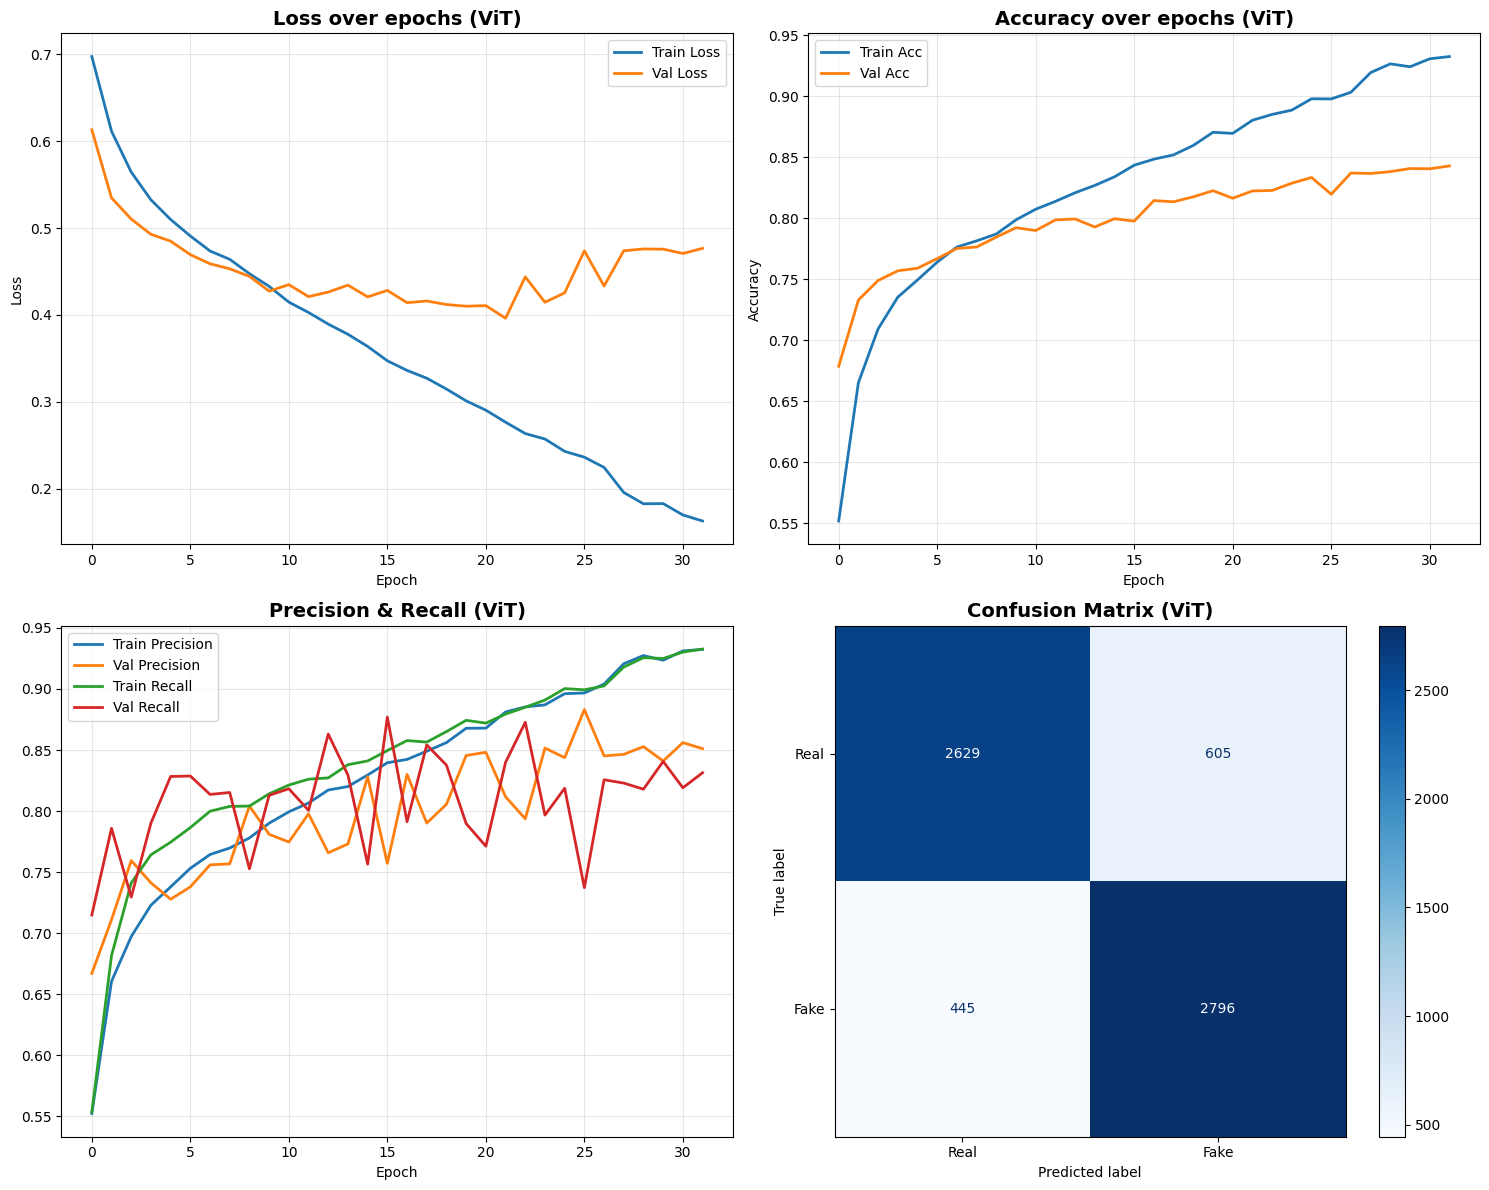

✓ Results saved to: vit_training_results.png


In [25]:
# ============================================================
# EVALUATE MODEL
# ============================================================
print("\n" + "="*60)
print("EVALUATING MODEL")
print("="*60)

test_loss, test_acc, test_precision, test_recall, test_auc = model.evaluate(
    test_dataset,
    verbose=1
)

print(f"\n{'='*60}")
print(f"FINAL RESULTS - VISION TRANSFORMER")
print(f"{'='*60}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"{'='*60}")

# Generate predictions
print("\nGenerating predictions...")
y_pred_proba = model.predict(test_dataset, verbose=1)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

# Get true labels
y_test = np.array([label for _, label, _ in test_files])

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Real', 'Fake']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# ============================================================
# VISUALIZE RESULTS
# ============================================================
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_title('Loss over epochs (ViT)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Acc', linewidth=2)
axes[0, 1].plot(history.history['val_accuracy'], label='Val Acc', linewidth=2)
axes[0, 1].set_title('Accuracy over epochs (ViT)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Precision & Recall
axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
axes[1, 0].plot(history.history['recall'], label='Train Recall', linewidth=2)
axes[1, 0].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
axes[1, 0].set_title('Precision & Recall (ViT)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Real', 'Fake'])
disp.plot(cmap='Blues', ax=axes[1, 1], values_format='d')
axes[1, 1].set_title('Confusion Matrix (ViT)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('vit_training_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Results saved to: vit_training_results.png")


In [ ]:
# ============================================================
# SAMPLE PREDICTIONS
# ============================================================
print("\n" + "="*60)
print("SAMPLE PREDICTIONS")
print("="*60)

sample_data = list(test_dataset.take(1))[0]
X_sample = sample_data[0]
y_sample = sample_data[1].numpy()

X_freq_sample = X_sample[0][:10]
X_mobile_sample = X_sample[1][:10]
y_sample = y_sample[:10]

y_pred_sample = model.predict([X_freq_sample, X_mobile_sample], verbose=0)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i in range(min(10, len(X_freq_sample))):
    ax = axes[i // 5, i % 5]
    freq_img = X_freq_sample[i][:, :, 0]
    ax.imshow(freq_img, cmap='viridis')
    
    pred_prob = y_pred_sample[i][0]
    true_label = "Fake" if y_sample[i] == 1 else "Real"
    pred_label = "Fake" if pred_prob > 0.5 else "Real"
    color = 'green' if true_label == pred_label else 'red'
    
    ax.set_title(f"True: {true_label}\nPred: {pred_label} ({pred_prob:.2f})",
                 color=color, fontweight='bold', fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.savefig('vit_sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Predictions saved to: vit_sample_predictions.png")



In [27]:
# ============================================================
# SAVE MODEL
# ============================================================
print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

model.save('deepfake_vit_model.keras')
print("✓ Model saved: deepfake_vit_model.keras")

model_size = os.path.getsize('deepfake_vit_model.keras') / 1024 / 1024
print(f"✓ Model size: {model_size:.2f} MB")

print("\n" + "="*60)
print("✅ TRAINING COMPLETE - VISION TRANSFORMER!")
print("="*60)


SAVING MODEL
✓ Model saved: deepfake_vit_model.keras
✓ Model size: 70.28 MB

✅ TRAINING COMPLETE - VISION TRANSFORMER!
